# Earth quake
> graph laplacian

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [7]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

1. 데이터 정의

In [8]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2010"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/02/2010,12.4240,141.9490,6.1,2010
1,01/03/2010,-5.2970,145.8590,5.8,2010
2,01/03/2010,-8.8020,-77.7180,5.7,2010
3,01/03/2010,-8.7260,157.4870,6.6,2010
4,01/03/2010,-8.7830,157.3540,7.1,2010
...,...,...,...,...,...
3569,12/28/2016,38.3917,-118.8941,5.6,2016
3570,12/28/2016,38.3777,-118.8957,5.5,2016
3571,12/28/2016,36.9179,140.4262,5.9,2016
3572,12/29/2016,-9.0283,118.6639,6.3,2016


2. 실제 $f(x) = y$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [243]:
f = _df.loc[:,"Magnitude"]

In [ ]:
f_true = _df.loc[:,"Magnitude"]

In [ ]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

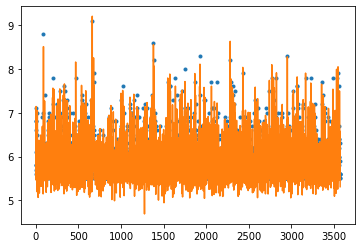

In [23]:
plt.plot(f_true,'.')
plt.plot(f,'-')

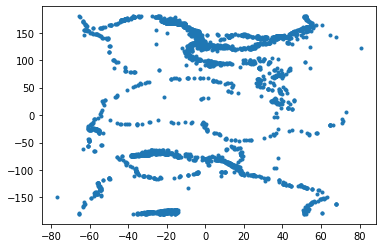

In [24]:
plt.plot( _df.Latitude,_df.Longitude,'.')

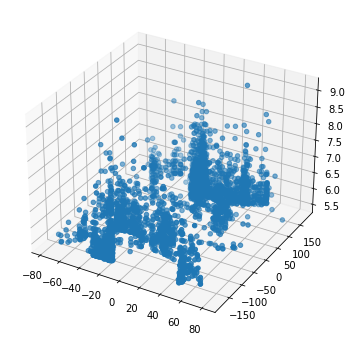

In [25]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude)
#ax.scatter(_df.Latitude, _df.Longitude, 0)

3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
    - 반대편으로 갈 수 있는 경우 반대편 각을 구하기 위하여 경도 차이의 절대값이 180도를 넘는 경우 360도를 빼주는 조건 추가

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [244]:
def dist(i,j):
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 180: 
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i] -360)**2) )  
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1이 될터.)

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [450]:
def weight(i,j,theta=10,kappa=100):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [451]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [452]:
W.round(3)

array([[1.   , 0.193, 0.   , ..., 0.049, 0.007, 0.044],
       [0.193, 1.   , 0.   , ..., 0.   , 0.023, 0.   ],
       [0.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.049, 0.   , 0.   , ..., 1.   , 0.   , 0.994],
       [0.007, 0.023, 0.   , ..., 0.   , 1.   , 0.   ],
       [0.044, 0.   , 0.   , ..., 0.994, 0.   , 1.   ]])

그래프

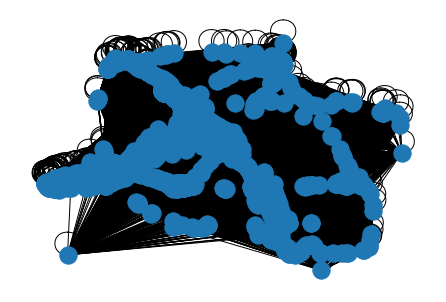

In [453]:
nx.draw(nx.Graph(W))

5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [454]:
D = np.diag(W.sum(axis=1))

In [455]:
D

array([[164.33094434,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 294.92437446,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 107.11255664, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 438.94841962,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        148.18880748,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 442.39425896]])

6. Graph Laplacian matrix 정의
- $L = D - W$

In [456]:
L = D - W

In [457]:
L

array([[ 1.63330944e+02, -1.92702119e-01,  0.00000000e+00, ...,
        -4.92251658e-02, -6.65767279e-03, -4.41669038e-02],
       [-1.92702119e-01,  2.93924374e+02,  0.00000000e+00, ...,
        -1.16448029e-04, -2.31102204e-02, -9.97372908e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.06112557e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.92251658e-02, -1.16448029e-04,  0.00000000e+00, ...,
         4.37948420e+02, -2.44062848e-06, -9.94026527e-01],
       [-6.65767279e-03, -2.31102204e-02,  0.00000000e+00, ...,
        -2.44062848e-06,  1.47188807e+02, -1.57119318e-06],
       [-4.41669038e-02, -9.97372908e-05,  0.00000000e+00, ...,
        -9.94026527e-01, -1.57119318e-06,  4.41394259e+02]])

7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [458]:
λ, Ψ = np.linalg.eig(L)

In [459]:
Λ = np.diag(λ)

---

In [460]:
_sortidx = np.argsort(λ)
_sortidx

array([  2, 377,   4, ...,  37,  36,  35])

In [461]:
_vector = Ψ

In [462]:
_value = _value[_sortidx]
_vector = _vector[:, _sortidx]

In [463]:
_vector.shape

(3574, 3574)

---

푸리에

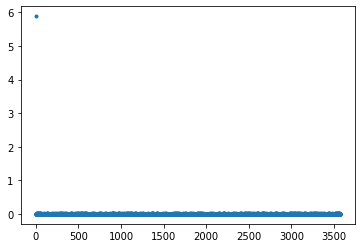

In [464]:
fbar = np.abs(np.fft.fft(f))/len(f)
plt.plot(fbar,'.')

In [465]:
fbar[0] 

5.886091214325686

In [466]:
len(f)/2

1787.0

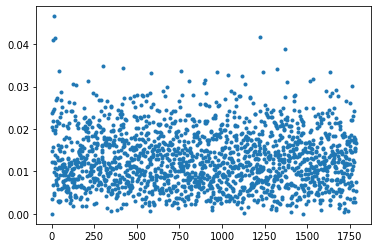

In [467]:
fbar2=np.zeros(1787)
#fbar2[0] = fbar[0] 
fbar2[0] = 0
fbar2[1:1787] = 2*fbar[1:1787]
plt.plot(fbar2,'.')

In [468]:
fbar2[:10]

array([0.        , 0.02045955, 0.01231799, 0.01475486, 0.02367782,
       0.00346245, 0.01570452, 0.02185756, 0.01988036, 0.02434497])

---

8. $f \times \Psi \times \Psi^\top $

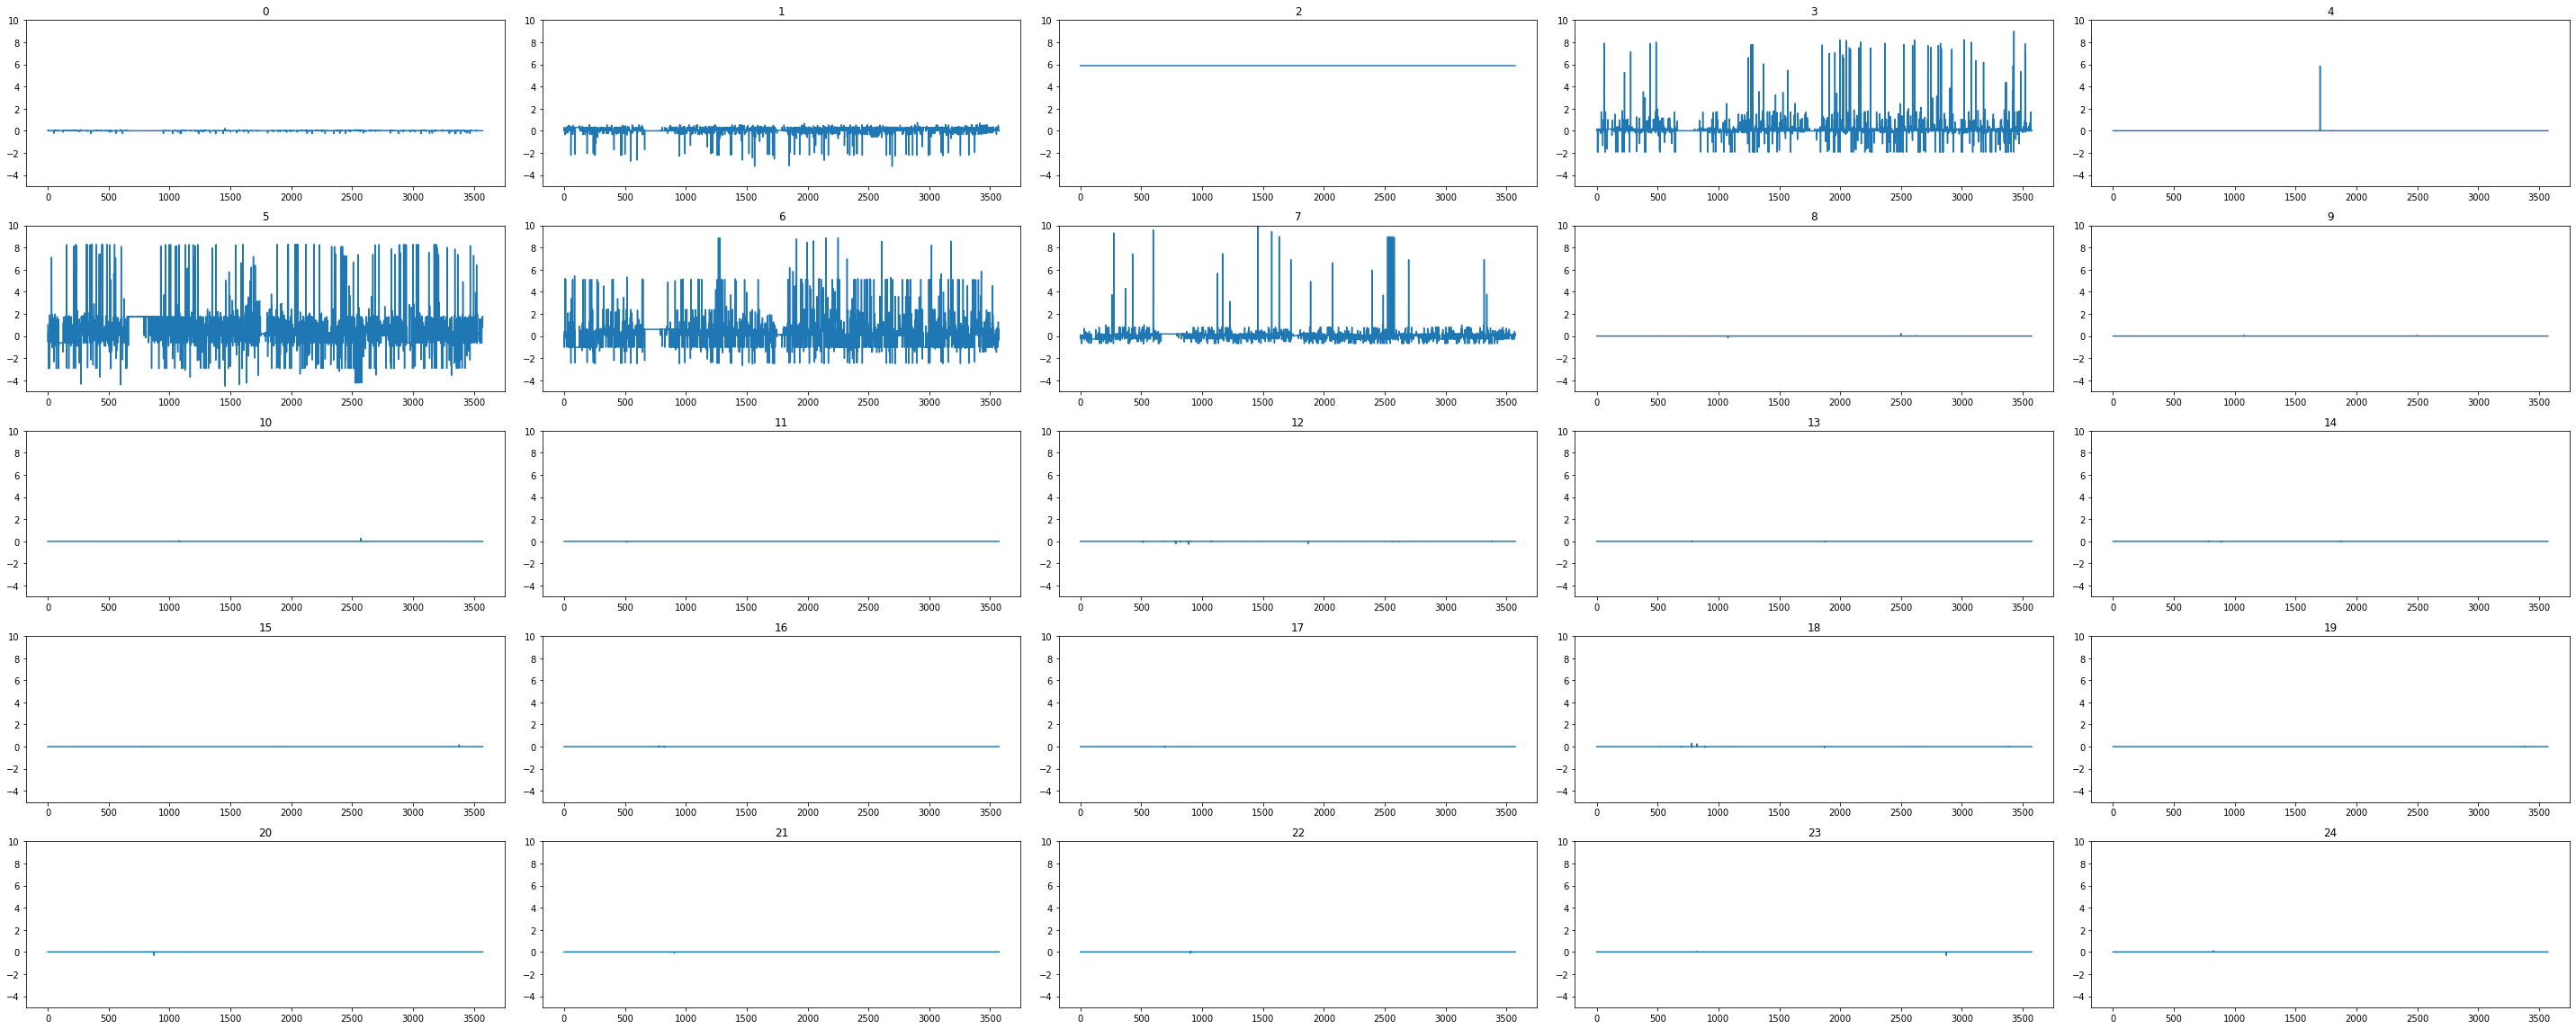

In [469]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-5,10])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(40)            
fig.set_figheight(16)
fig.tight_layout()        

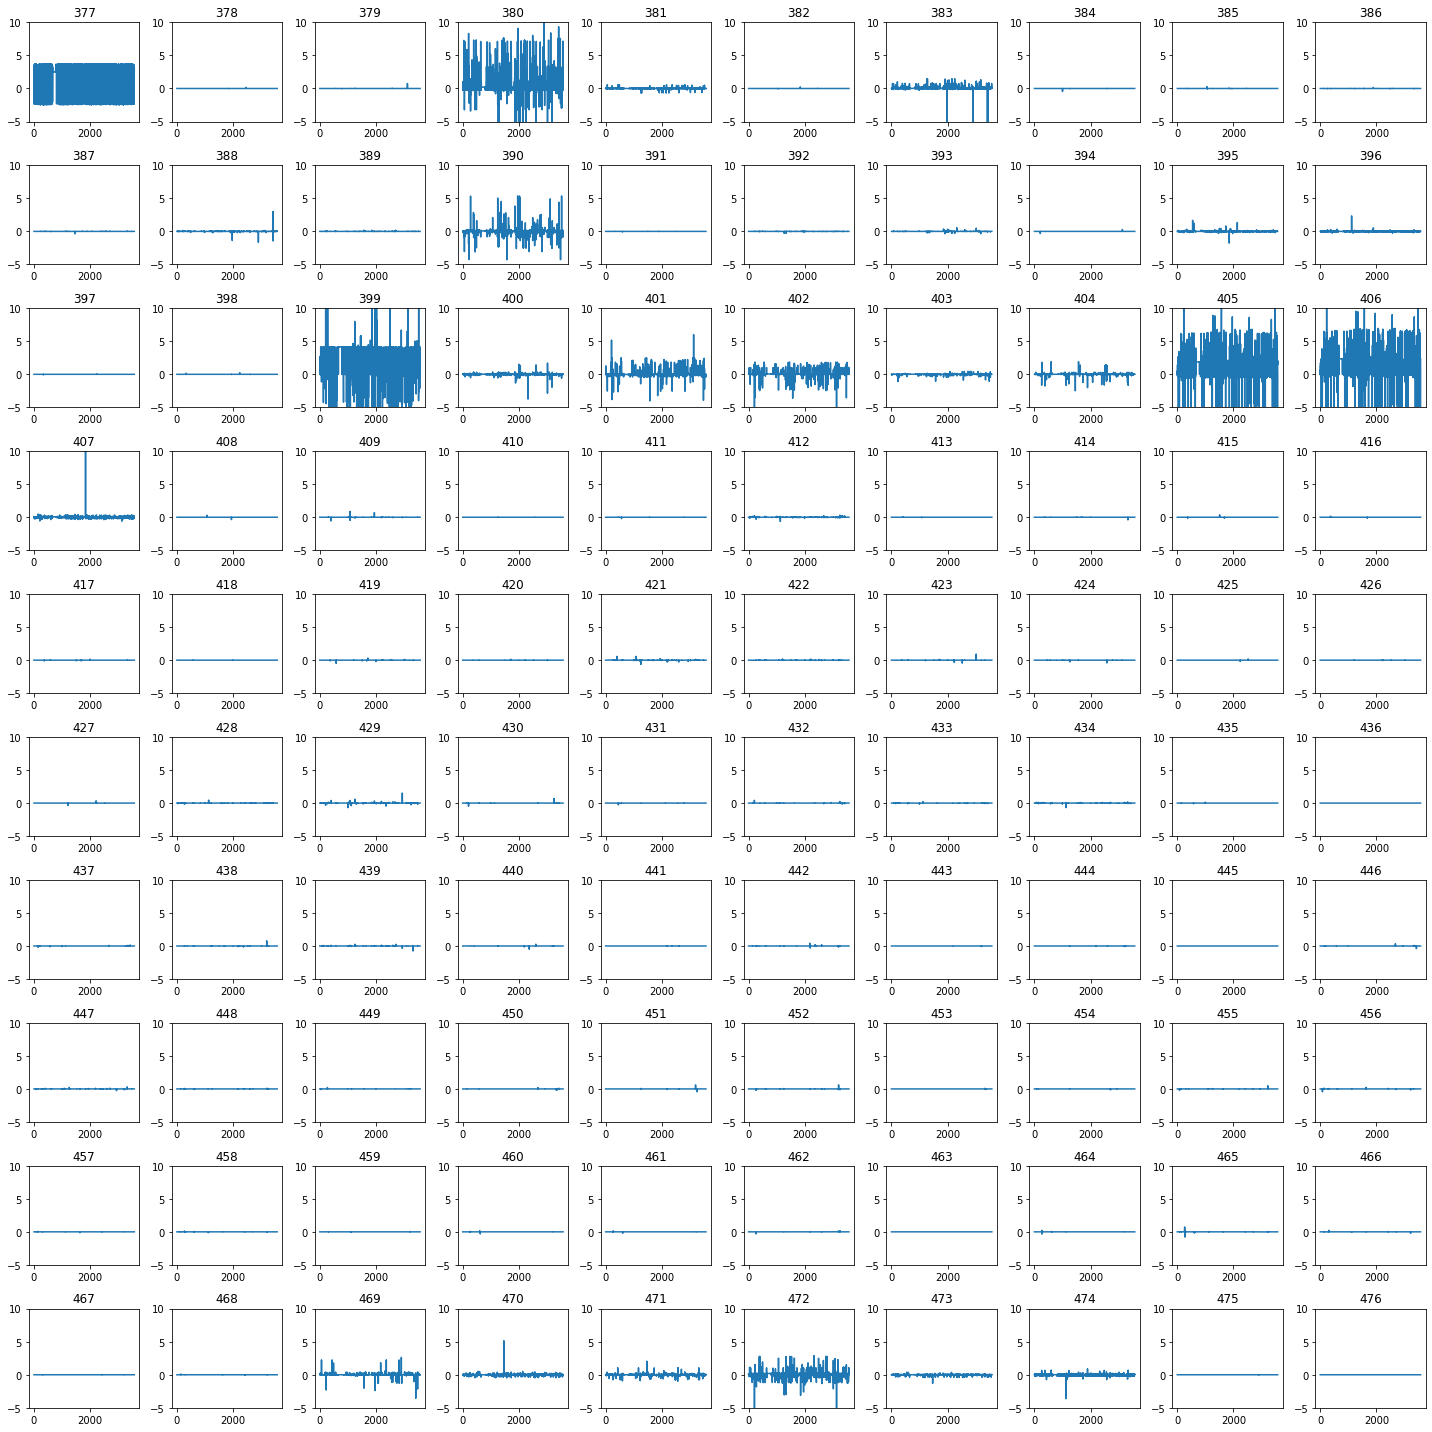

In [528]:
fig,ax =plt.subplots(10,10)
k=377
for i in range(10):
    for j in range(10):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-5,10])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(20)            
fig.set_figheight(20)
fig.tight_layout()        

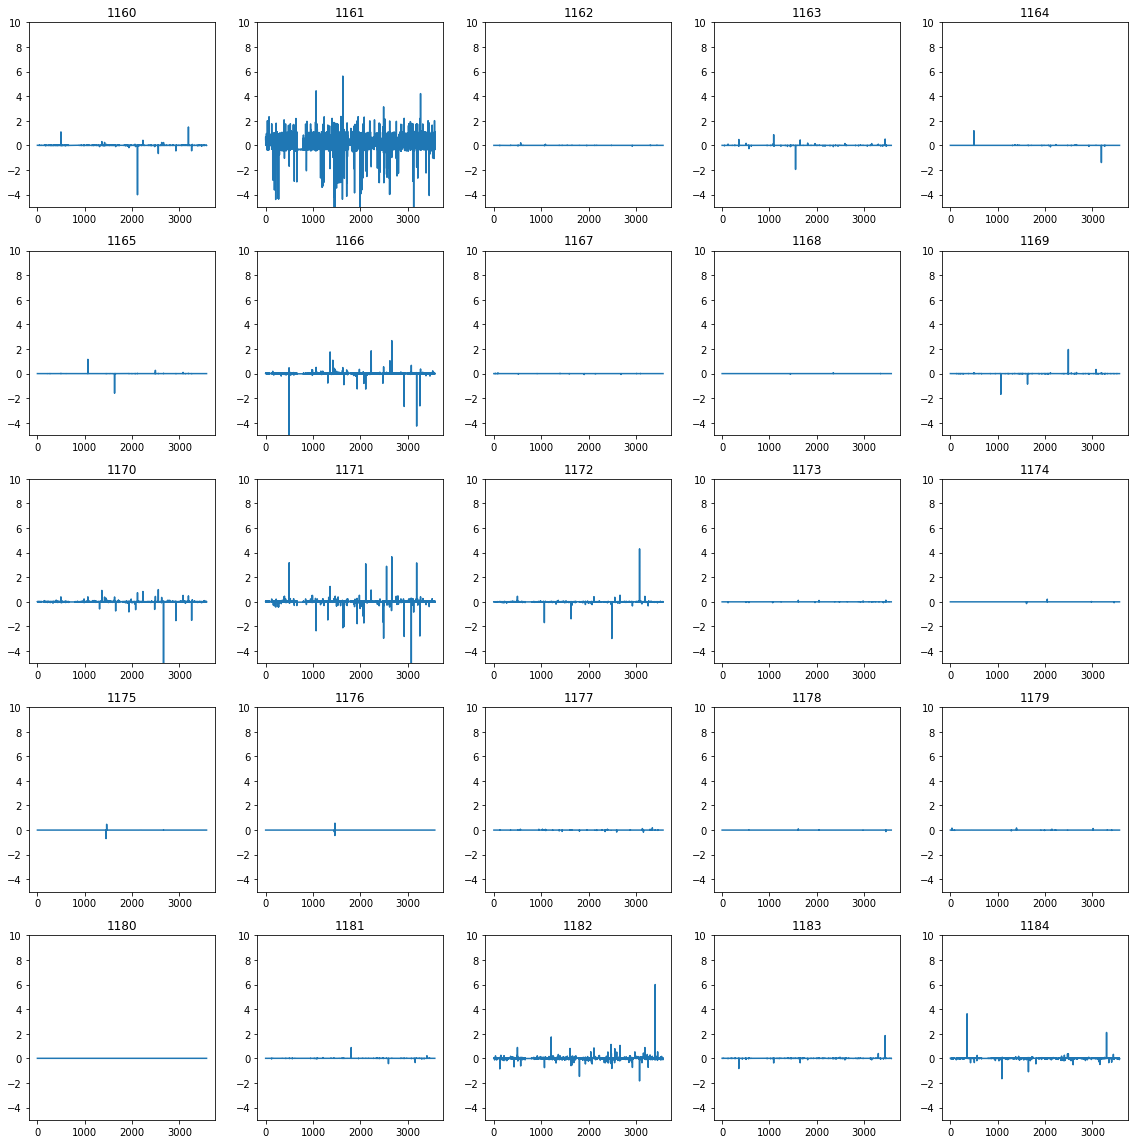

In [529]:
fig,ax =plt.subplots(5,5)
k=1160
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-5,10])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

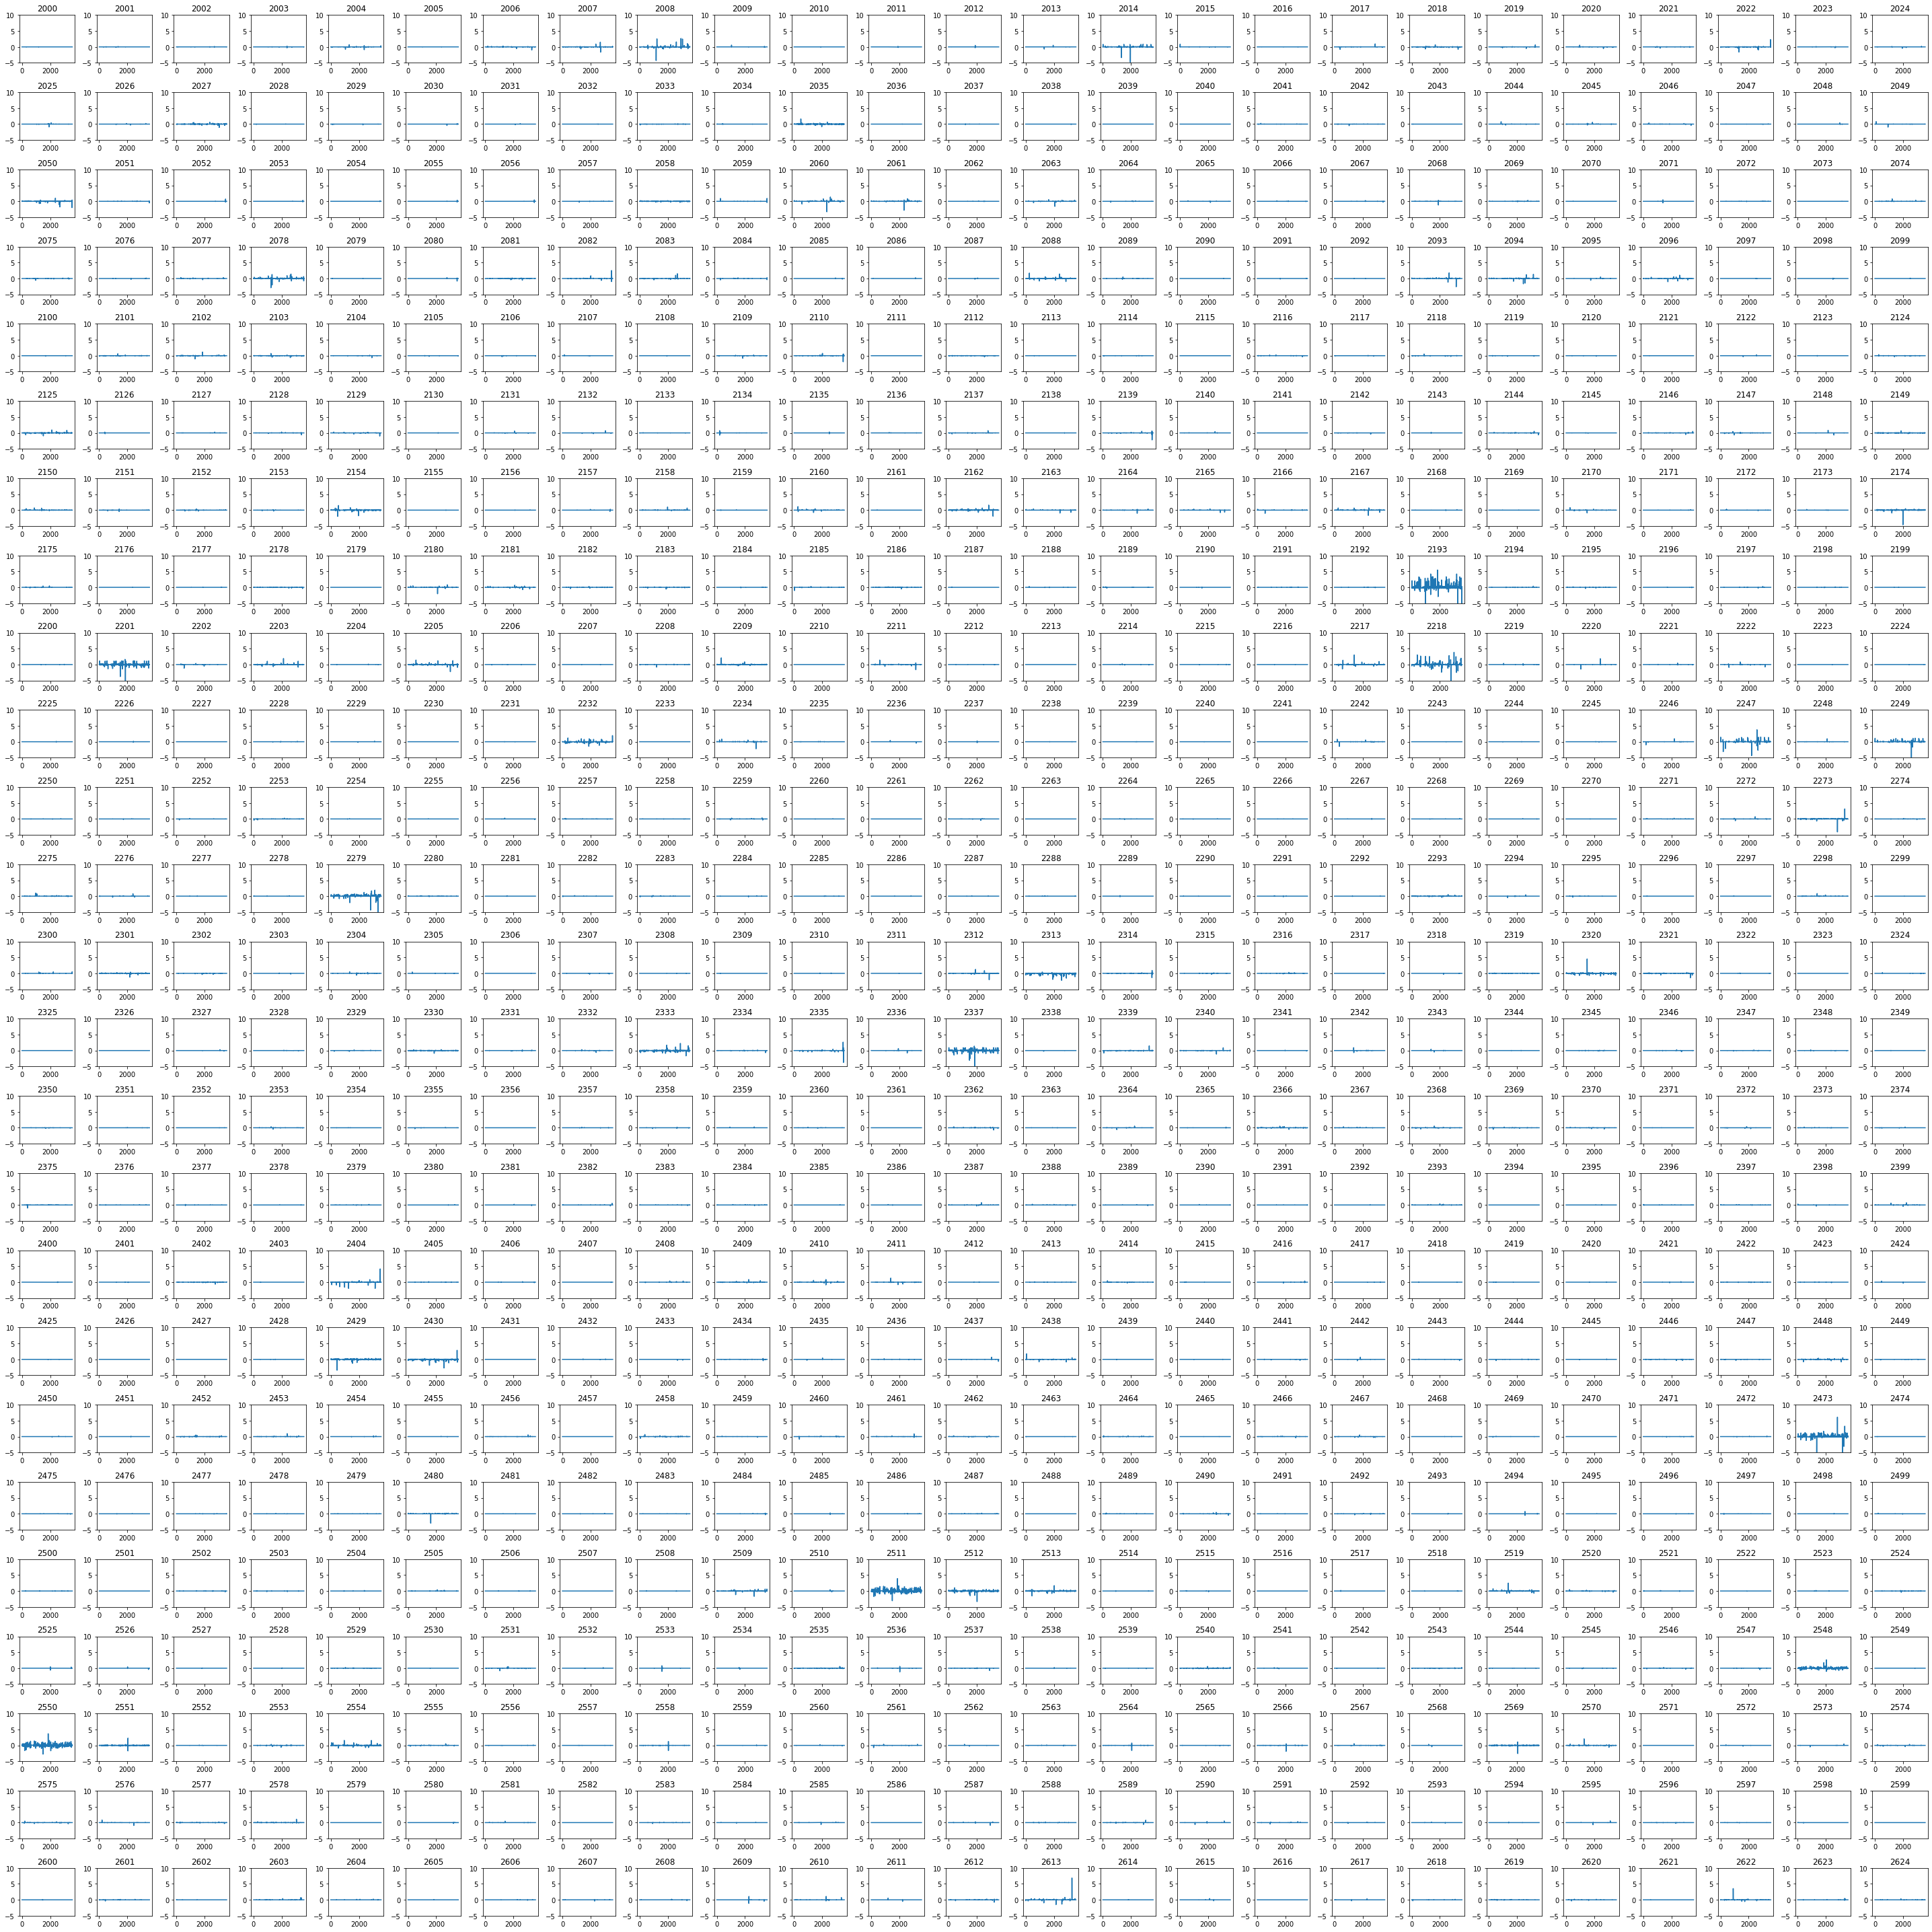

In [518]:
fig,ax =plt.subplots(25,25)
k=2000
for i in range(25):
    for j in range(25):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-5,10])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(40)            
fig.set_figheight(40)
fig.tight_layout()        

평균을 나타내는 component

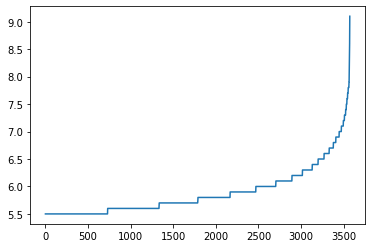

In [476]:
plt.plot(f[np.argsort(f)].reset_index().iloc[:,1])

In [552]:
f[np.argsort(f)].reset_index().iloc[:,1][3573]

9.1

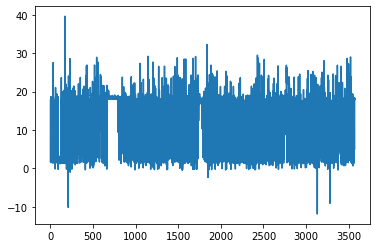

In [505]:
plt.plot(f @ Ψ[:,np.argsort(λ)] @ Ψ[:,np.argsort(λ)].T)

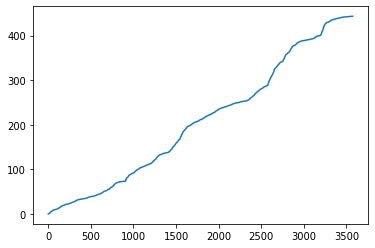

In [506]:
plt.plot(λ[np.argsort(λ)])

In [507]:
np.mean(f)

5.886091214325686

In [530]:
np.mean(f @ np.outer(Ψ[:,2], Ψ[:,2]))

5.886091214325552

In [531]:
comphat1=f @ np.outer(Ψ[:,2], Ψ[:,2])

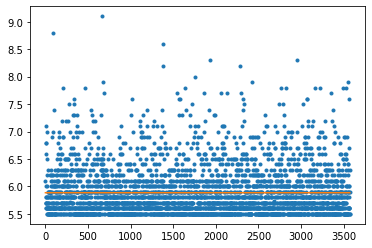

In [532]:
plt.plot(f,'.')
plt.plot(comphat1,'-')

comphat1 뺀 f 추정

In [543]:
comphat2 =  f @ np.outer(Ψ[:,381], Ψ[:,381])  + f @ np.outer(Ψ[:,471], Ψ[:,471])  + f @ np.outer(Ψ[:,473], Ψ[:,473]) 

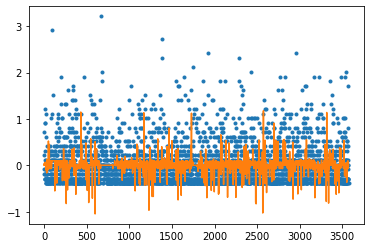

In [544]:
plt.plot(f-comphat1,'.')
plt.plot(comphat2,'-')

In [545]:
comphat3 =  f @ np.outer(Ψ[:,405], Ψ[:,405]) + f @ np.outer(Ψ[:,406], Ψ[:,406])

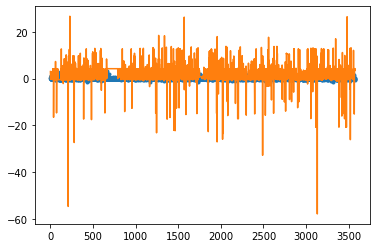

In [546]:
plt.plot(f-comphat1-comphat2,'.')
plt.plot(comphat3)

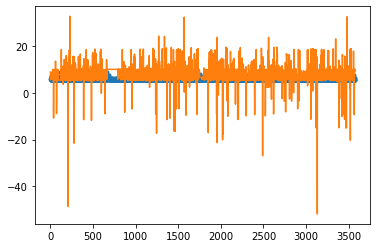

In [547]:
plt.plot(f,'.')
plt.plot(comphat1 + comphat2 + comphat3)